# Reef Net Calcification

### This section outlines the process for collection and cleaning of data from the eReefs dataset

In [35]:
import numpy as np
import numpy.ma as ma
import pandas as pd
import netCDF4 as nc
import xarray as xr

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
plt.ion()  # To trigger the interactive inline mode

import seaborn as sns
import cmocean

%matplotlib inline

## 1. First we load a dataset. 

Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:

In [2]:
#Data set loaded from thredds server

df = xr.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml")


## 2. Variable selection

Here we select the necesary variables from the larger dataset for our model

In [3]:
ds = df[[ 'temp', 'Gnet', 'PH', 'botz']]


Identify the spatial limits of the of the data

In [4]:
print(' model spatial extent:\n')
print(' - Longitudinal extent:',np.nanmin(ds['longitude']),np.nanmax(ds['longitude']))
print(' - Latitudinal extent:',np.nanmin(ds['latitude']),np.nanmax(ds['latitude']))


 model spatial extent:

 - Longitudinal extent: 142.168788 156.8856378
 - Latitudinal extent: -28.6960218 -7.0119082


In [5]:
# Removing non-finite values
ds.latitude.values = np.nan_to_num(ds.latitude.values)
ds.longitude.values = np.nan_to_num(ds.longitude.values)

# Check the arrays shapes
print(ds.longitude)

<xarray.DataArray 'longitude' (j: 180, i: 600)>
array([[142.168788 , 142.1804468, 142.19211  , ...,   0.       ,
          0.       ,   0.       ],
       [142.2013204, 142.2123752, 142.2236158, ...,   0.       ,
          0.       ,   0.       ],
       [142.2333969, 142.2441535, 142.25509  , ...,   0.       ,
          0.       ,   0.       ],
       ...,
       [147.8135068, 147.8142988, 147.8153794, ..., 156.8042355,
        156.8051407, 156.8061819],
       [147.8353694, 147.8363158, 147.8375886, ..., 156.84433  ,
        156.8451114, 156.8460513],
       [147.8566896, 147.8580363, 147.8596273, ..., 156.8843511,
        156.8849406, 156.8856378]])
Coordinates:
    longitude  (j, i) float64 142.2 142.2 142.2 142.2 ... 156.9 156.9 156.9
    latitude   (j, i) float64 -8.074 -8.107 -8.139 ... -28.52 -28.56 -28.59
Dimensions without coordinates: j, i
Attributes:
    standard_name:    longitude
    long_name:        Longitude
    units:            degrees_east
    coordinate_type:  long

In [6]:
# Mask nans
lat = ma.masked_invalid(ds.latitude.values)
lon = ma.masked_invalid(ds.longitude.values)

# Check the arrays shapes
print(lon.shape,lat.shape)


(180, 600) (180, 600)


# 3. Reef Selection

Next we select the reef of interest within the bounds of the GBR

In [7]:

## Northern Reefs ##
#Davies Reef
# reeflat, reeflon = -18.823797, 147.637696

#Yule Reef
# reeflat, reeflon = -11.949075, 143.985203

# key Reef
# reeflat, reeflon = -12.228707, 143.279144


## Southern Reefs ##
#Heron Reef 
reeflat, reeflon = -23.450571, 151.950123

We need to make sure the coordinates we provide are translated to the data we have and so we code to recieve the closest corresponding point

In [8]:
# Find the closest point base on the coordinates (lon, lat) we can do that a bit better with a kd-tree if you want
# to analyse multiple reefs
j_idx, i_idx = np.where((np.abs(lat-reeflat)<0.02)&(np.abs(lon-reeflon)<0.02))
j_reef = j_idx[0]
i_reef = i_idx[0]



In [9]:
# Checking the returned i,j index:
print('Reef lon position ',reeflon,' Found closest lon position in the data ',lon[j_reef,i_reef])
print('Reef lat position ',reeflat,' Found closest lat position in the data ',lat[j_reef,i_reef])


Reef lon position  151.950123  Found closest lon position in the data  151.9327198
Reef lat position  -23.450571  Found closest lat position in the data  -23.4408406


Now that we have the position (j,i) in the dataset we can extract the variables at this specific location and depth (-1.5 m):

In [10]:
# Number of vertical points along the z-coordinate model
zc = df['zc'][:]
nlay = len(zc)

print('Number of vertical layers',nlay)

for k in range(nlay):
    print(f'  + vertical layer {k} is at {df.zc[k].values} m')

Number of vertical layers 47
  + vertical layer 0 is at -3890.0 m
  + vertical layer 1 is at -3680.0 m
  + vertical layer 2 is at -3480.0 m
  + vertical layer 3 is at -3280.0 m
  + vertical layer 4 is at -3080.0 m
  + vertical layer 5 is at -2880.0 m
  + vertical layer 6 is at -2680.0 m
  + vertical layer 7 is at -2480.0 m
  + vertical layer 8 is at -2280.0 m
  + vertical layer 9 is at -2080.0 m
  + vertical layer 10 is at -1880.0 m
  + vertical layer 11 is at -1680.0 m
  + vertical layer 12 is at -1480.0 m
  + vertical layer 13 is at -1295.0 m
  + vertical layer 14 is at -1135.0 m
  + vertical layer 15 is at -990.0 m
  + vertical layer 16 is at -865.0 m
  + vertical layer 17 is at -755.0 m
  + vertical layer 18 is at -655.0 m
  + vertical layer 19 is at -570.0 m
  + vertical layer 20 is at -495.0 m
  + vertical layer 21 is at -430.0 m
  + vertical layer 22 is at -370.0 m
  + vertical layer 23 is at -315.0 m
  + vertical layer 24 is at -270.0 m
  + vertical layer 25 is at -235.0 m
  + 

In [11]:
# We can see that a -1.5 m depth coresponds with k = 43.
reef_Gnet = ds.sel(k=(43))
reef_Gnet = reef_Gnet.sel(j=j_reef, i=i_reef).drop_vars({'longitude','latitude', 'botz', 'zc'})
reef_Gnet


<xarray.Dataset>
Dimensions:  (time: 1178)
Coordinates:
  * time     (time) datetime64[ns] 2016-11-01T02:00:00 ... 2019-11-28T02:00:00
Data variables:
    temp     (time) float32 ...
    Gnet     (time) float32 ...
    PH       (time) float32 ...
Attributes:
    Run_ID:       2.0
    hasVocab:     1
    title:        GBR4 BGC (Spectral) Transport
    paramhead:    GBR 4km resolution grid
    paramfile:    in.prm
    ems_version:  v1.0 rev(5997)
    Conventions:  CF-1.0

There needs to be some final data cleaning due to duplicates in the time series

In [12]:
# step 1
reef_Gnet["time"] = reef_Gnet["time"].dt.floor("D")

# step 2
val,idx = np.unique(reef_Gnet.time, return_index=True)
reef_Gnet = reef_Gnet.isel(time=idx)

## 4. Confirm data is present
By querying the min/max net calcification we can confirm that point selected has calcification data

In [13]:
print(' model Gnet limits:\n')
print(' - Gnet min/max:',np.nanmin(reef_Gnet['Gnet']),np.nanmax(reef_Gnet['Gnet']))


 model Gnet limits:

 - Gnet min/max: 0.024382103 0.033046875


## 5. Visual summary of data collected

Summary plots to assess the validity of data obtained, this enables the review of data and its quality for use in calcification forecasting.



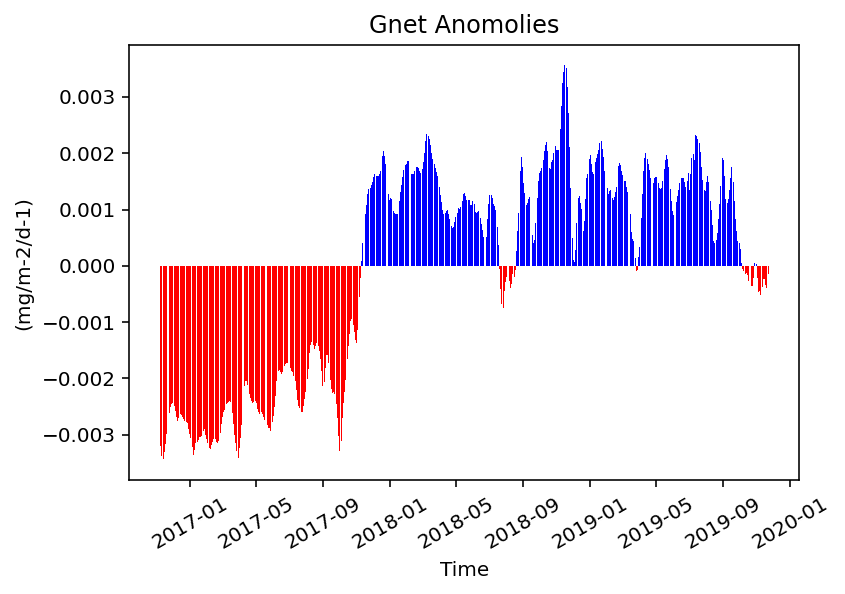

In [49]:
gb = reef_Gnet.groupby('time.month')

ds_anom = gb - gb.mean(dim='time')
ds_anom

ds_anom_rolling = ds_anom.rolling(time=12, center=True).mean()


plt.bar(ds_anom_rolling['time'], ds_anom_rolling['Gnet'], 
        color=np.where(ds_anom_rolling['Gnet'] < 0, 'r', 'b'))
plt.xticks(rotation=30)
plt.ylabel('(mg/m-2/d-1)')
plt.xlabel('Time')
plt.title('Gnet Anomolies')

plt.show()


The level correlation between Temperature/pH and Gnet will impact later modelling. The greater the correlation the more accurate the model will be.

Text(0.5, 1.0, 'Gnet Versus pH')

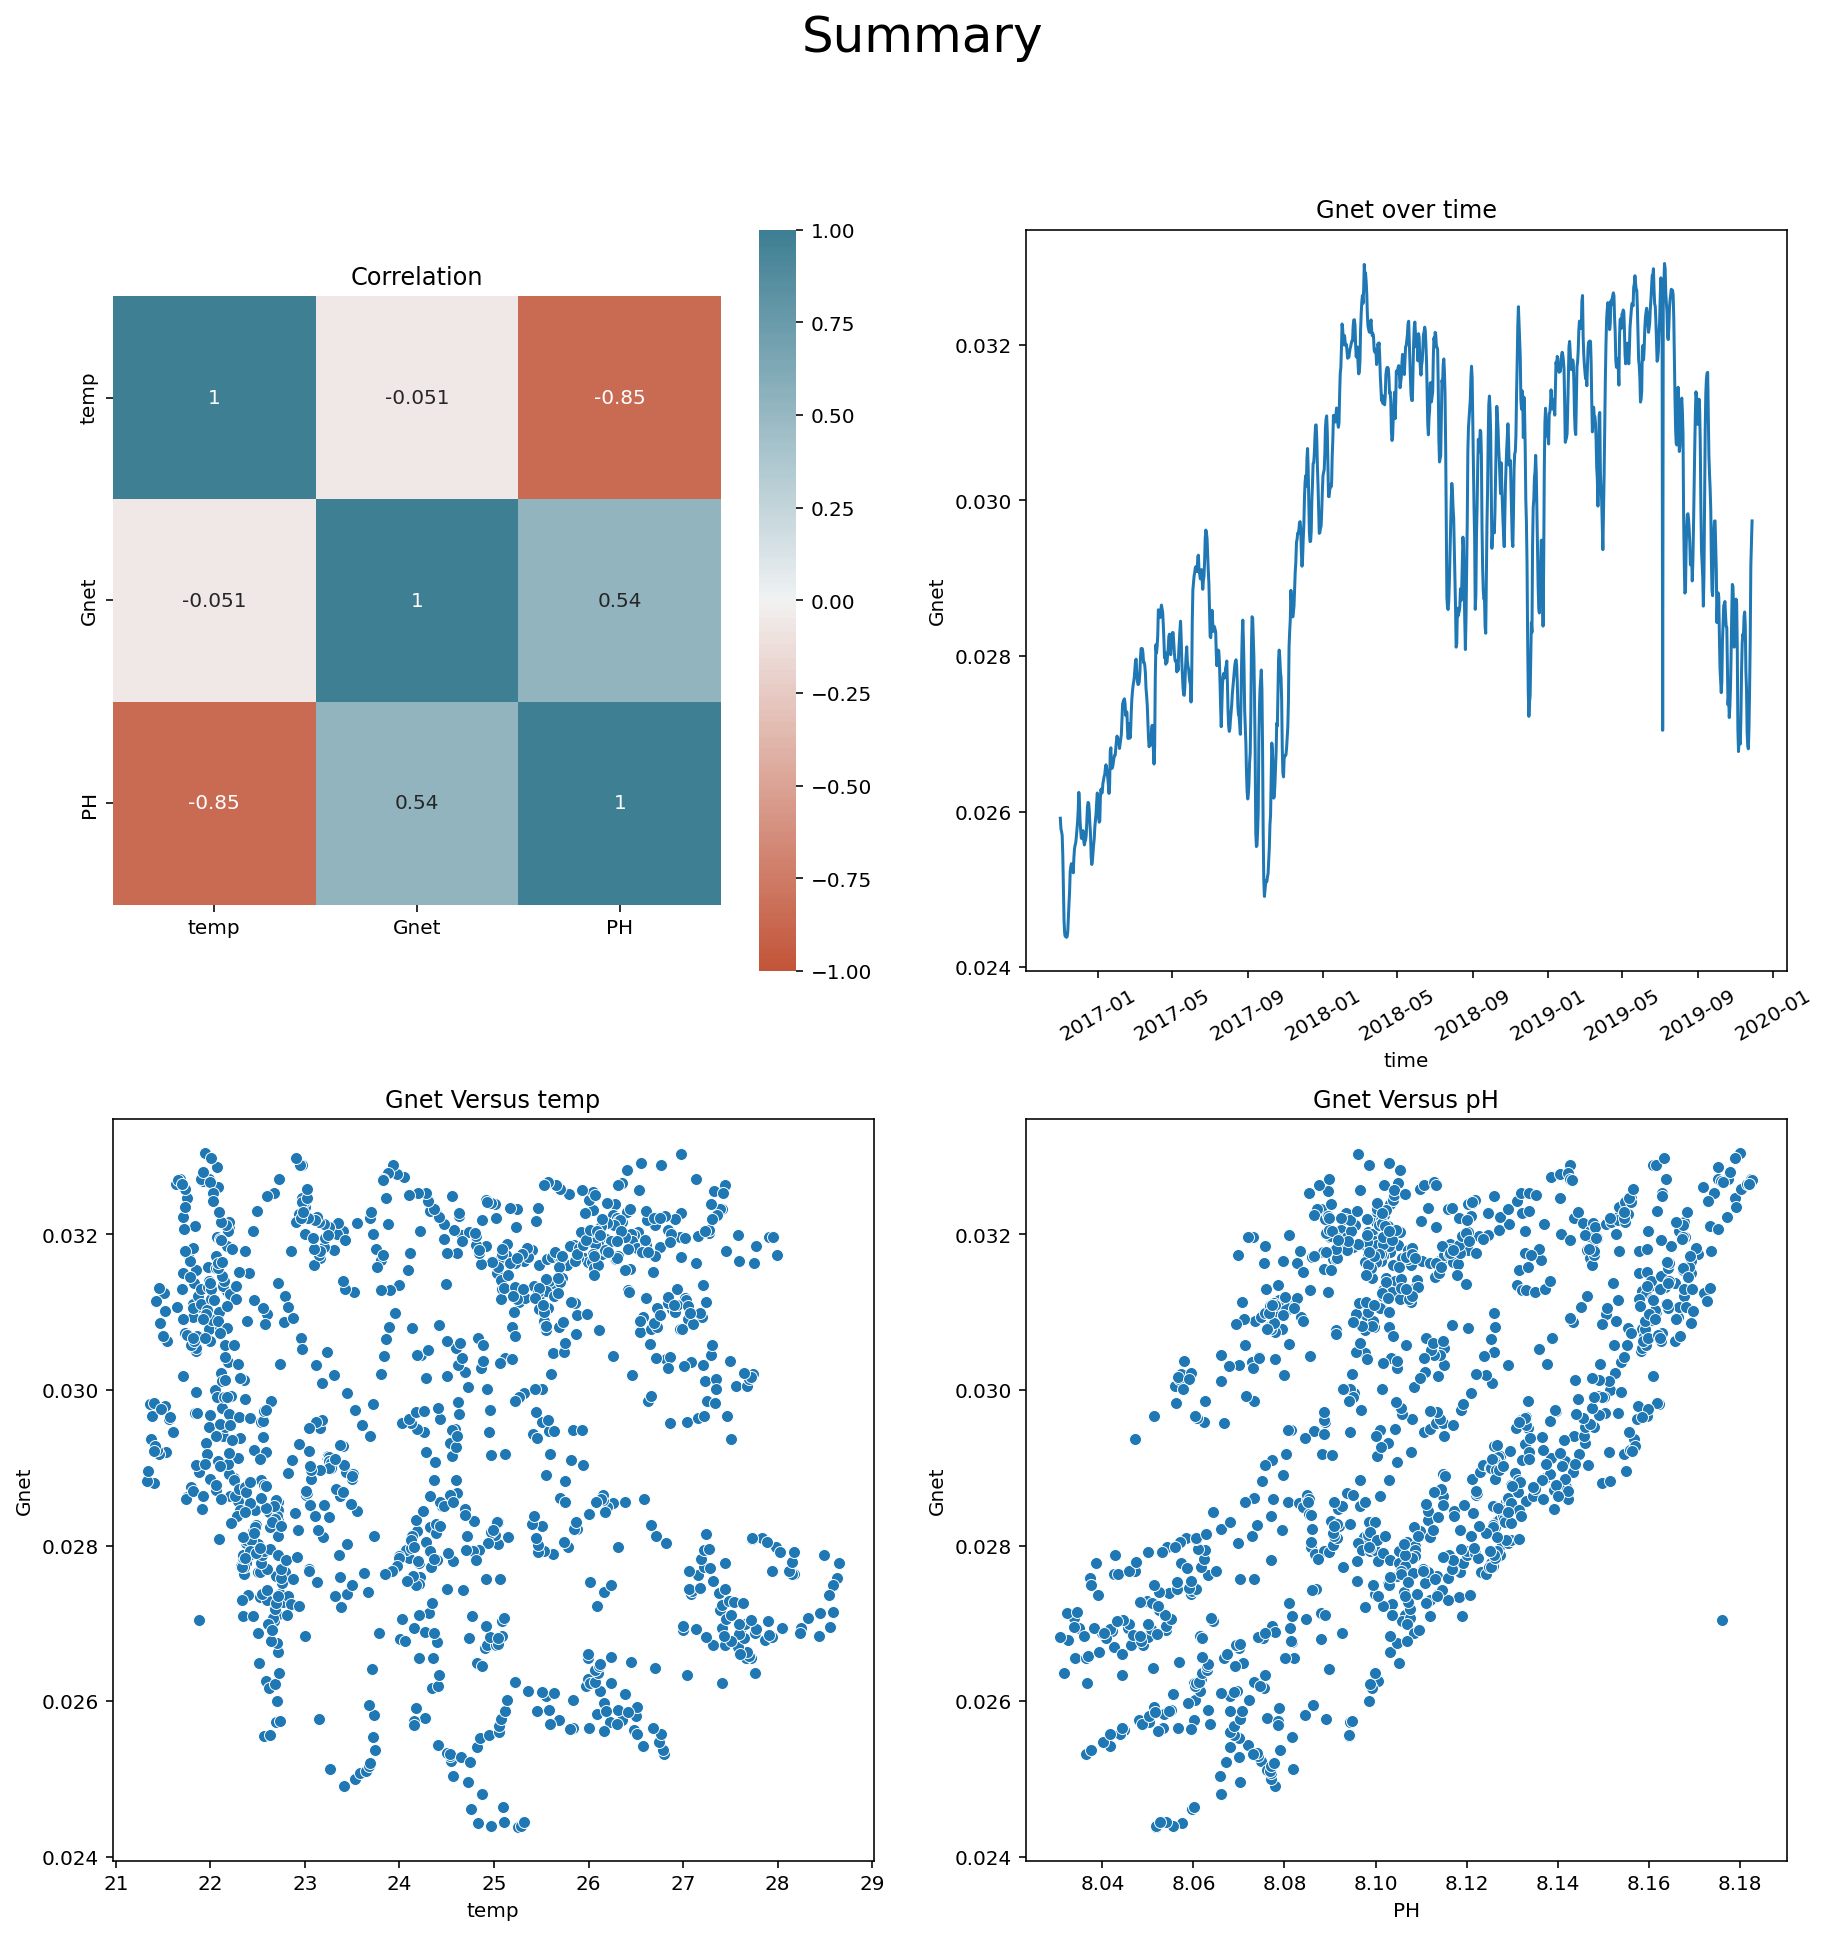

In [22]:
reef_Gnet_pd = reef_Gnet.to_dataframe()
fig, axes = plt.subplots(2,2,figsize=(15,15))

corr = reef_Gnet_pd.corr()

sns.heatmap(corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True, annot=True, ax= axes[0,0])

ax = sns.lineplot(data=reef_Gnet_pd, x='time', y='Gnet',ax= axes[0,1]) 
axes[0,1].tick_params(axis='x', labelrotation=30)

sns.scatterplot(data = reef_Gnet_pd, x='PH',y='Gnet',ax= axes[1,1])
sns.scatterplot(data = reef_Gnet_pd, x='temp',y='Gnet',ax= axes[1,0])

plt.suptitle("Summary", fontsize=25)
axes[0,0].set_title('Correlation')
axes[0,1].set_title('Gnet over time')
axes[1,0].set_title('Gnet Versus temp')
axes[1,1].set_title('Gnet Versus pH')


Now that the data has been checked it can be saved into the reefs data file.

In [ ]:
# reef_Gnet.to_netcdf('Reef-Data/Heron_reef.nc')

## 6. Creation of function

Now that we have confirmed the above process provides the required data we can create a function in order to expedite the process of collecting Gnet data for each reef

In [17]:
def Gnet_data(reef_lat, reef_lon):

    '''
    This funtion collects and cleans data from the eReefs netCDF
    file available on the AIMS OpenDAP server.
    
    https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml
    
    args:
    
    - reef_lat : latitudinal coordinate of reef location
    - reef_lon : longitudinal coordinate of reef location
    '''
    
    # Required packages for function.
    import numpy as np
    import numpy.ma as ma
    import pandas as pd
    import xarray as xr

    from matplotlib import pyplot as plt
    %config InlineBackend.figure_format = 'retina'
    plt.ion()  # To trigger the interactive inline mode

    import seaborn as sns
    import cmocean

    %matplotlib inline

    # First we load a dataset. 

    # Since the data is provided via an [OPeNDAP](https://en.wikipedia.org/wiki/OPeNDAP) server, we can load it directly without downloading anything:
    df = xr.open_dataset("https://dapds00.nci.org.au/thredds/dodsC/fx3/model_data/gbr4_bgc_GBR4_H2p0_B2p0_Chyd_Dnrt.ncml")
    df


    # Variable selection

    # Here we select the necesary variables from the larger dataset for our model

    ds = df[[ 'temp', 'Gnet', 'PH', 'botz']]
    ds

    print(' model spatial extent:\n')
    print(' - Longitudinal extent:',np.nanmin(ds['longitude']),np.nanmax(ds['longitude']))
    print(' - Latitudinal extent:',np.nanmin(ds['latitude']),np.nanmax(ds['latitude']))


    # Removing non-finite values
    ds.latitude.values = np.nan_to_num(ds.latitude.values)
    ds.longitude.values = np.nan_to_num(ds.longitude.values)

    # Mask nans
    lat = ma.masked_invalid(ds.latitude.values)
    lon = ma.masked_invalid(ds.longitude.values)


    # Reef Selection
    # Next we select the reef of interest within the bounds of the GBR

    reeflat, reeflon = reef_lat, reef_lon

    #We need to make sure the coordinates we provide are trnaslated to the data wee have and so we code to recieve the closest corresponding point

    # Find the closest point base on the coordinates (lon, lat) we can do that a bit better with a kd-tree if you want
    # to analyse multiple reefs
    j_idx, i_idx = np.where((np.abs(lat-reeflat)<0.02)&(np.abs(lon-reeflon)<0.02))
    j_reef = j_idx[0]
    i_reef = i_idx[0]



    # Checking the returned i,j index:
    print(' Closest data point found to input coordinates:\n')
    print(' - Reef lon position ',reeflon,' Found closest lon position in the data ',lon[j_reef,i_reef])
    print(' - Reef lat position ',reeflat,' Found closest lat position in the data ',lat[j_reef,i_reef])


    # Now that we have the position (j,i) in the dataset we can extract the variables at this specific location:

    reef_Gnet = ds.sel(k=(43))
    reef_Gnet = reef_Gnet.sel(j=j_reef, i=i_reef).drop_vars({'longitude','latitude', 'botz', 'zc'})
    reef_Gnet


    # There needs to be some final data cleaning due to duplicates in the time series

    # step 1
    reef_Gnet["time"] = reef_Gnet["time"].dt.floor("D")

    # step 2
    val,idx = np.unique(reef_Gnet.time, return_index=True)
    reef_Gnet = reef_Gnet.isel(time=idx)

    # By querying the min/max net calcification we can confirm that point selected has calcification Data

    print(' model Gnet limits:\n')
    print(' - Gnet min/max:',np.nanmin(reef_Gnet['Gnet']),np.nanmax(reef_Gnet['Gnet']))


    # Summary plots to assess the validity of data obtained

    reef_Gnet_pd = reef_Gnet.to_dataframe()
    fig, axes = plt.subplots(2,2,figsize=(15,15))

    corr = reef_Gnet_pd.corr()

    sns.heatmap(corr, 
        vmin=-1, vmax=1, center=0,
        cmap=sns.diverging_palette(20, 220, n=200),
        square=True, annot=True, ax= axes[0,0])

    ax = sns.lineplot(data=reef_Gnet_pd, x='time', y='Gnet',ax= axes[0,1]) 
    axes[0,1].tick_params(axis='x', labelrotation=30)


    sns.scatterplot(data = reef_Gnet_pd, x='PH',y='Gnet',ax= axes[1,1])
    sns.scatterplot(data = reef_Gnet_pd, x='temp',y='Gnet',ax= axes[1,0])

    plt.suptitle("Summary", fontsize=25)
    axes[0,0].set_title('Correlation')
    axes[0,1].set_title('Gnet over time')
    axes[1,0].set_title('Gnet Versus temp')
    axes[1,1].set_title('Gnet Versus pH')
    
    return reef_Gnet

In [ ]:
Reef_Gnet = Gnet_data(-18.823797,147.637696)

In [ ]:
# Reef_Gnet.to_netcdf('Reef-Data/Davies_reef.nc')

In [ ]:
Reef_Gnet

In [ ]:
# Reef_Gnet.to_netcdf('Reef-Data/Lizard_island_reef.nc')

Now that we have created the function and stored in in a .py file we can call it to continue sourcing reef data

In [ ]:
Reef_Gnet= Gnet_data(-17.534715, 146.386063)